# Using MNE-Python for frequency and time-frequency analysis

    Authors: Britta Westner, partly based on MNE-Python tutorials and examples
    License: BSD (3-clause)

Let's dive into MNE-Python! We will get to know MNE-Python's way of working by conducting some frequency and time-frequency decompositions.

In the first part, we will explore some parts of MNE-Python together. In later parts, you will get to answer questions (exploring the data and code) and do some exercises (fixing and writing code).

I hope your MNE-Python journey won't end there - and you'll go explore our tutorials and examples as well!

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import mne
from mne.datasets import somato

Above, we imported the packages we will be using. MNE-Python, of course, but also NumPy, SciPy, and Matplotlib. As you can see, we are again using shorthand for some of them, e.g., importing the module `pyplot` from Matplotlib as `plt`- so we have to write only `plt.plot()` instead of `matplotlib.pyplot.plot()`. 

And we are doing the same for `mne.datasets.somato`, which we shorten to `somato` - more about this dataset below!

Lastly, we added `%matplotlib inline` to force our figures to be embedded into the notebook by default.

## The dataset

For our MNE-Python adventure, we are using a dataset that is available from within MNE-Python. If you followed the setup instructions, you will have already downloaded it. If not - don't worry, the code below will prompt MNE to download the data _if it has not been downloaded yet_. 

The dataset is called `somato`, referring to the paradigm: somatosensory stimulation was applied to elicit event-related (de-)synchronization in the beta-band.

In [2]:
# mne.set_log_level('error')  # suppress some of MNE's output to keep the notebook slim

data_path = somato.data_path(download=True)  # download the data if necessary

# construct the path to the raw file
raw_fname = data_path / 'sub-01/meg/sub-01_task-somato_meg.fif'

## Read the data and inspect the raw file

Let's start with the raw data. The data is MEG data from an Elekta system. These files are also known as fif-Files, and we can read them in with the fif-reader of MNE-Python. 

MNE-Python has readers for an exhaustive list of systems! You can see (some) of them by starting to type `mne.io.read` in the code cell below and see what autocompletion gives you. - A neat trick for when you have trouble fully remembering a function name!

A more exhaustive way is to consult the **API Reference** on the MNE-Python webpage: https://mne.tools/stable/api/file_io.html


In [ ]:
# try out what autocompletion gives you for mne.io.read
# start typing! - depending on your system/IDE you might also have to hit tab for completion


In [11]:
# read the raw file
raw = mne.io.read_raw_fif(raw_fname)

Opening raw data file C:\Users\timdr\mne_data\MNE-somato-data\sub-01\meg\sub-01_task-somato_meg.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.


We can look at the so-called info object that is part of the `Raw` object. This has handy information about your data!

In [4]:
raw.info

<Info | 22 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 acq_stim: 1 10.000000 8040.000000 1 10.000000 8233.000000 1 10.000000 ...
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 1 EOG
 custom_ref_applied: False
 description: Kainulainen (jarika) VectorView system at HUT
 dev_head_t: MEG device -> head transform
 dig: 47 items (3 Cardinal, 4 HPI, 40 Extra)
 events: 1 item (list)
 experimenter: Jari
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 100.1 Hz
 meas_date: 2007-07-05 11:17:11 UTC
 meas_id: 4 items (dict)
 nchan: 316
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: particles
 projs: []
 sfreq: 300.3 Hz
 subject_info: <subject_info | id: 175, sex: 1>
>

And we can of course plot the data. Here, you could for example also mark bad trials and channels (to which we will take a simple automated approach today). The data browser should open in a new window or be operable within the notebook - however, this is not fool-proof with Jupyter Notebooks. Another reason to not rely on them too strictly throughout your data analysis!

In [10]:
raw.plot()

Channels marked as bad:
none


In [8]:
# look at what changed in raw
raw.info

<Info | 22 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 acq_stim: 1 10.000000 8040.000000 1 10.000000 8233.000000 1 10.000000 ...
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 1 EOG
 custom_ref_applied: False
 description: Kainulainen (jarika) VectorView system at HUT
 dev_head_t: MEG device -> head transform
 dig: 47 items (3 Cardinal, 4 HPI, 40 Extra)
 events: 1 item (list)
 experimenter: Jari
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 100.1 Hz
 meas_date: 2007-07-05 11:17:11 UTC
 meas_id: 4 items (dict)
 nchan: 316
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: particles
 projs: []
 sfreq: 300.3 Hz
 subject_info: <subject_info | id: 175, sex: 1>
>

In [ ]:
raw.annotations

In [ ]:
# if you messed with raw, it's a good idea to reload it :)
raw = mne.io.read_raw_fif(raw_fname)

## Epoch the data

Time to learn how to epoch the data into trials!

For that we of course need triggers - that is quite an easy setup here: we have only one trigger value and one trigger channel. The `event_id` (the trigger value) is 1.

We will cut fairly long epochs: from -1 to 3 seconds around the event. We will already baseline-correct our events with a baseline extending to 0.

Another thing we want to set up is which channels to keep when epoching: we will keep only the MEG gradiometers (the system has magnetometers, too!) and the EOG (which we will use for data cleaning).

And finally, we use some simple heuristic to disregard noisy trials, based on cut-off values.

In [12]:
# setting up all our parameters for epoching

# identify events and specify epoching parameters
events = mne.find_events(raw, stim_channel='STI 014')
event_id, tmin, tmax = 1, -1., 3.
baseline = (None, 0)

# specify which channels to keep after epoching
picks = mne.pick_types(raw.info, meg='grad', eeg=False, eog=True, stim=False)

# rejecting trials based on a simple heuristic
rejecting = dict(grad=4000e-13, eog=350e-6)

111 events found on stim channel STI 014
Event IDs: [1]


In [13]:
# We can look at the events array:
events

array([[239647,      0,      1],
       [242115,      0,      1],
       [244325,      0,      1],
       [247008,      0,      1],
       [249407,      0,      1],
       [251602,      0,      1],
       [254022,      0,      1],
       [256235,      0,      1],
       [258480,      0,      1],
       [260777,      0,      1],
       [262966,      0,      1],
       [265437,      0,      1],
       [267662,      0,      1],
       [270324,      0,      1],
       [272795,      0,      1],
       [275020,      0,      1],
       [277401,      0,      1],
       [280003,      0,      1],
       [282366,      0,      1],
       [284534,      0,      1],
       [287185,      0,      1],
       [289685,      0,      1],
       [291880,      0,      1],
       [294447,      0,      1],
       [296969,      0,      1],
       [299179,      0,      1],
       [301742,      0,      1],
       [303970,      0,      1],
       [306219,      0,      1],
       [308714,      0,      1],
       [31

Now for the actual epoching - we give all this information to the `Epochs` class - it will make our `epochs` object!

In [14]:
epochs = mne.Epochs(
    raw,
    events,
    event_id, 
    tmin,
    tmax,
    picks=picks,
    baseline=baseline,
    reject=rejecting,
    preload=True
)

Not setting metadata
111 matching events found
Setting baseline interval to [-0.9989760657919393, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 111 events and 1202 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
3 bad epochs dropped


In [15]:
epochs

<Epochs | 108 events (all good), -0.999 – 3 s (baseline -0.999 – 0 s), ~206.2 MiB, data loaded,
 '1': 108>

## Some MNE-Python idiosyncracies

Let's dive into some of the things to be aware of when working with Python and MNE-Python!

Let's first make a _copy_ of our epochs - it will become clear why :)

We can do this with a _method_ that belongs to the `epochs` object.

In [16]:
test_epochs = epochs.copy()

MNE-Python makes it possible to chain methods:

<div class="alert alert-warning">
    <b>QUESTION</b>:
     <ul>
    <li> Look at the code below: what operations do you expect to happen and in which order?</li>
    </ul>
</div>

**Answer**: 

Setting up low-pass filter at 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 265 samples (0.882 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.9s
[Parallel(n_job

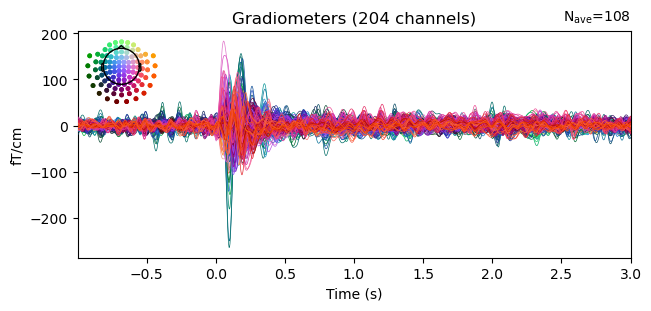

In [17]:
test_epochs.filter(l_freq=None, h_freq=15.).average().plot();

<div class="alert alert-warning">
    <b>QUESTION</b>:
     <ul>
    <li> What do you think happened to test_epochs?</li>
    </ul>
</div>

**Answer**: 

Well ... let's find out by plotting and comparing it to our original epochs!

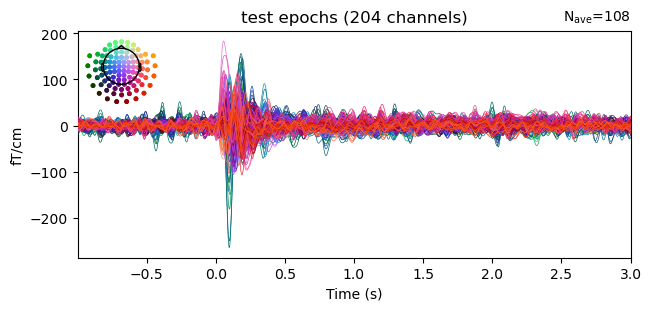

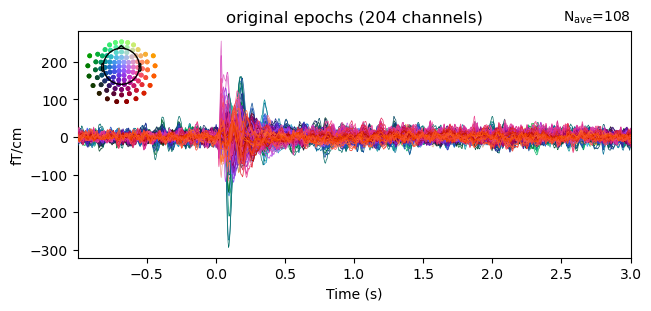

In [18]:
test_epochs.average().plot(titles='test epochs');
epochs.average().plot(titles='original epochs');

How can I find out which methods an object has?
- via tab / auto completion
- looking at the API reference of the class: https://mne.tools/stable/generated/mne.Epochs.html
- calling `dir()`

In [19]:
dir(epochs)

['__class__',
 '__contains__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_allow_empty',
 '_annotations',
 '_bad_dropped',
 '_channel_type_idx',
 '_check_consistency',
 '_check_metadata',
 '_compute_aggregate',
 '_current',
 '_data',
 '_data_sel_copy_scale',
 '_decim',
 '_decim_slice',
 '_detrend_offset_decim',
 '_detrend_picks',
 '_do_baseline',
 '_do_delayed_proj',
 '_evoked_from_epoch_data',
 '_filename',
 '_get_channel_positions',
 '_get_data',
 '_get_epoch_from_raw',
 '_get_name',
 '_getitem',
 '_handle_empty',
 '_handle_tmin_tmax',
 '_is_g

... and how do I know if a method operates _in place_?!

Look at the documentation!
- either online or:
- by calling for help from within Python :)

In [20]:
?epochs.filter

Signature:
epochs.filter(
    l_freq,
    h_freq,
    picks=None,
    filter_length='auto',
    l_trans_bandwidth='auto',
    h_trans_bandwidth='auto',
    n_jobs=None,
    method='fir',
    iir_params=None,
    phase='zero',
    fir_window='hamming',
    fir_design='firwin',
    skip_by_annotation=('edge', 'bad_acq_skip'),
    pad='edge',
    *,
    verbose=None,
)
Docstring:
Filter a subset of channels/vertices.

Parameters
----------

l_freq : float | None
    For FIR filters, the lower pass-band edge; for IIR filters, the lower
    cutoff frequency. If None the data are only low-passed.

h_freq : float | None
    For FIR filters, the upper pass-band edge; for IIR filters, the upper
    cutoff frequency. If None the data are only high-passed.
picks : str | array-like | slice | None
    Channels to include. Slices and lists of integers will be interpreted as 
    channel indices. In lists, channel *type* strings (e.g., ``['meg', 
    'eeg']``) will pick channels of those types, chann

You can also find out whether an object has, e.g., been filtered by looking at it's print-out:

In [21]:
test_epochs

<Epochs | 108 events (all good), -0.999 – 3 s (baseline -0.999 – 0 s), ~206.2 MiB, data loaded,
 '1': 108>

## Frequency analysis

Now that we have covered some of the workings of MNE-Python, let's get to our actual task: frequency decomposition!

We start by exploring the frequency content of our epochs (without time-resolution): let's check out the **power spectrum**!

We choose the multitaper method here - the `bandwidth` parameter controls the spectral resolution (how many tapers). You can increase the resolution by choosing a narrower bandwidth at the cost of longer computation time.

In [22]:
epochs_psd = epochs.compute_psd(method='multitaper', fmin=2., fmax=45., bandwidth=2.)

    Using multitaper spectrum estimation with 7 DPSS windows


In [23]:
# as always, we can get some insight by printing the object
epochs_psd

Data type,Power Spectrum
Units,grad: (T/m)²/Hz
Data source,Epochs
Number of epochs,108
Dims,"epoch, channel, freq"
Estimation method,multitaper
Number of channels,204
Number of frequency bins,172
Frequency range,2.25 – 44.97 Hz


In [ ]:
# let's plot this - we force the notebook to open an extra, interactive figure
%matplotlib qt
epochs_psd.plot();

Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


c:\Users\timdr\miniconda3\envs\mne\Lib\site-packages\ipykernel\eventloops.py:145: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  el.exec() if hasattr(el, "exec") else el.exec_()
c:\Users\timdr\miniconda3\envs\mne\Lib\site-packages\ipykernel\eventloops.py:145: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  el.exec() if hasattr(el, "exec") else el.exec_()
c:\Users\timdr\miniconda3\envs\mne\Lib\site-packages\ipykernel\eventloops.py:145: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  el.exec() if hasattr(el, "exec") else el.exec_()
c:\Users\timdr\miniconda3\envs\mne\Lib\site-packages\numpy\lib\_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(ax

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
    <li> What is the name of the EEG channel with the highest power at the alpha peak?</li>
    <li> Based on this plot, what do you expect the topography at 9 Hz to look like?</li>
    <li> Can you find a way to confirm this (without writing any code)?</li>
    </ul>
</div>

**Answers:**


We can also look at the topographies of this power spectrum, e.g. for different frequency bands. Here, we have to specify a channel type!

Averaging across epochs before plotting...


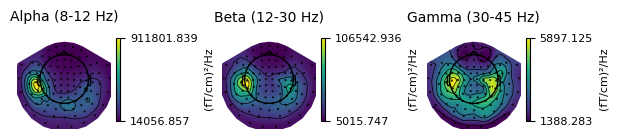

In [38]:
%matplotlib inline
bands = {'Alpha (8-12 Hz)': (8, 12), 
         'Beta (12-30 Hz)': (12, 30), 
         'Gamma (30-45 Hz)': (30, 45)}
epochs_psd.plot_topomap(ch_type='grad', bands=bands, normalize=False, cmap='viridis');

## Time-frequency analysis: power and inter-trial coherence

Let's now compute time-frequency representations (TFRs) from our Epochs.
We can also look at power and inter-trial coherence (ITC).

To this we'll use the method `epochs.compute_tfr()`, asking it to use Morlet wavelets for the decomposition.

In [26]:
# define frequencies of interest (log-spaced)
freqs = np.logspace(*np.log10([8, 45]), num=20)

# number of cycles 
n_cycles = 3.  

# compute the TFR using Morlet wavelets
power, itc = epochs.compute_tfr(
    method='morlet', 
    freqs=freqs, 
    n_cycles=n_cycles, 
    average=True,
    use_fft=True,
    return_itc=True, 
    decim=3, 
    n_jobs=1)

## Inspect time-frequency-resolved power


Let's look at the time-frequency spectra of all channels - in one plot!


<div class="alert alert-info"><h4>Note</h4><p>The generated figure is interactive. In the topo you can click
    on an image to visualize the data for one sensor.
    You can also select a portion in the time-frequency plane to
    obtain a topomap for a certain time-frequency region.</p></div>



Before we get there - let's also specify some parameters, namely: the baseline mode and length!

In [27]:
# Some setting for our baseline, which will be applied to the plots
baseline_mode = 'logratio' 
baseline = (-0.75, -0.1)

<div class="alert alert-warning">
    <b>QUESTION</b>:
     <ul>
    <li> We are moving a 3 cycles long time window. Is our baseline a good choice?</li>
    </ul>
</div>

**Answer:** 

Now, let's finally plot this!

In [40]:
%matplotlib qt
power.plot_topo(baseline=baseline, mode=baseline_mode, title='Average power');

Applying baseline correction (mode: logratio)


<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
    <li> Hummm ... This looks different than the power plots above. What looks different?</li>
    <li> Can you find out what's going on by experimenting with the plotting parameters?</li>
    <li> Going back to the "good" plot, identify the channel with the strongest beta increase.</li>
    </ul>
</div>

**Answers:** 


Let's plot one channel of interest - the one you identified above! 

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
    <li> Find the channel's index by completing the code below.</li>
    </ul>
</div>

In [43]:
chan_idx = power.ch_names.index('MEG 1142')  # complete this!

Let's plot the TFR of this one channel!

Applying baseline correction (mode: logratio)


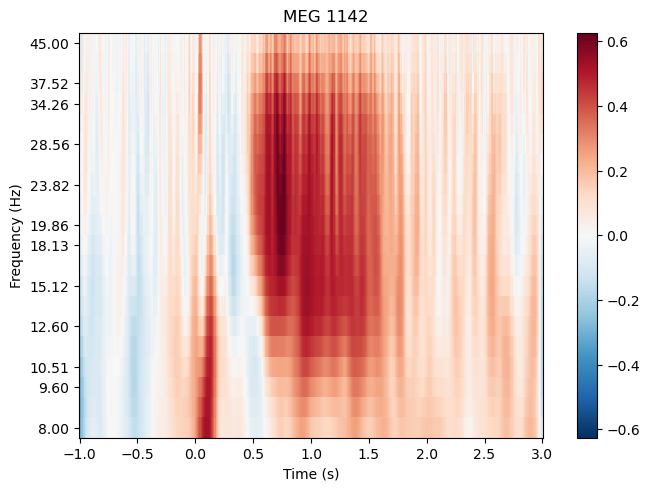

In [44]:
%matplotlib inline
power.plot(chan_idx, baseline=baseline, mode=baseline_mode, title=power.ch_names[chan_idx]);

We can also look at topographies again! 

We have done this above for the power spectra. Our TFR output has a similar method, however, not all parameters are the same. Below, you find the code for plotting the **beta band topography**. Let's assume you also want to plot the following bands:
- alpha: 8-12 Hz
- gamma: 30-45 Hz

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
    <li> Can you modify the code to plot all bands in a for-loop?</li>
    </ul>
</div>

Tips: 
- you can create a figure and axes object with `fig, axes = plt.subplots(1, 3, figsize=(7, 4))` and `power.plot_topomap()` takes an ax via the `axes` parameter
- you also have to suppress the immediate plotting of the figure (to not end up with only the first one): add `show=False` to your `power.plot_topomap()` call

Applying baseline correction (mode: logratio)


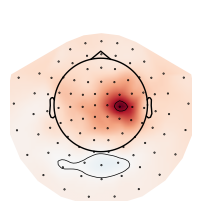

In [45]:
# code to plot beta band
power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.0, fmin=13., fmax=30., 
                   baseline=baseline, mode=baseline_mode, contours=1, colorbar=False);

In [ ]:
print(bands.items())


dict_items([('Alpha (8-12 Hz)', (8, 12)), ('Beta (12-30 Hz)', (12, 30)), ('Gamma (30-45 Hz)', (30, 45))])


dict_items

Applying baseline correction (mode: logratio)


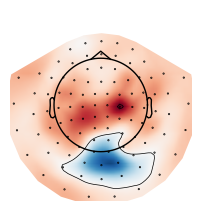

Alpha (8-12 Hz)
Applying baseline correction (mode: logratio)


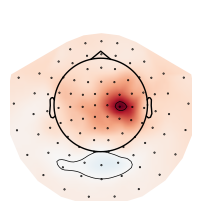

Beta (12-30 Hz)
Applying baseline correction (mode: logratio)


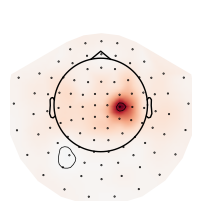

Gamma (30-45 Hz)


In [61]:
# Answer: for loop code
for band, (fmin, fmax) in bands.items():
    power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.0, fmin=fmin, fmax=fmax, 
                       baseline=baseline, mode=baseline_mode, contours=1, colorbar=False);
    print(band)



## Joint Plots

Pretty neat are the creation of joint plots showing both the aggregated TFR
across all channels and topomaps at specified times and frequencies to obtain
a quick overview regarding oscillatory effects across time and space.



Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


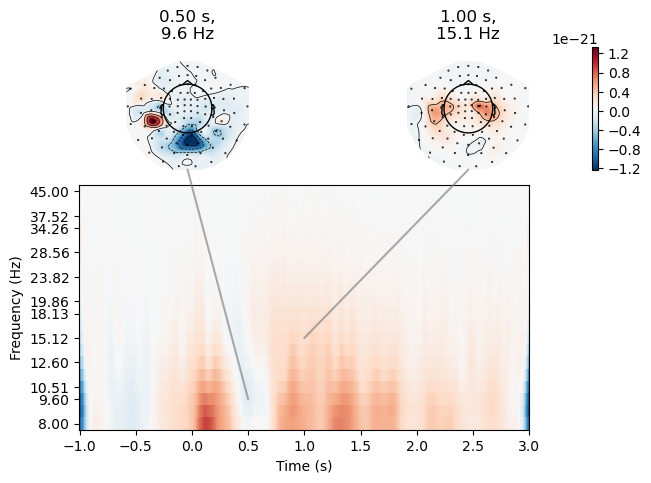

In [62]:
power.plot_joint(baseline=baseline, mode='mean', tmin=None, tmax=None,
                 timefreqs=[(0.5, 10.), (1., 15.)]);

# Inspect ITC

Oh, I almost forgot: we also computed the inter-trial coherence! Pretty good idea to check if we want to distinguish induced from evoked activity! This one will show us activity that is phase-locked across trials and can thus be assumed to be evoked!


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


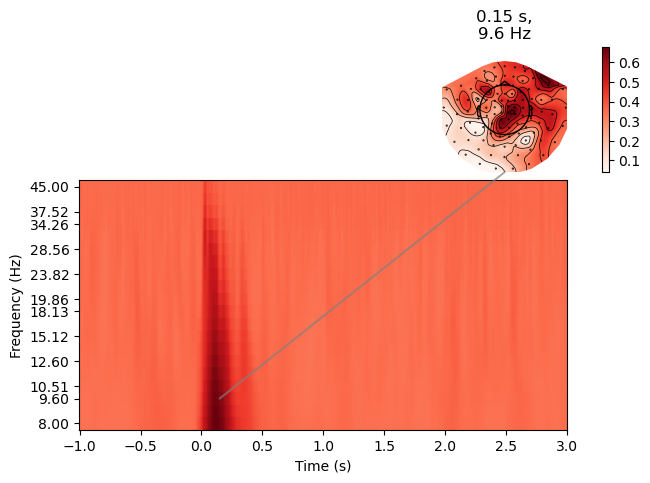

In [63]:
%matplotlib inline
itc.plot_joint(baseline=baseline, mode='mean', tmin=None, tmax=None,
                 timefreqs=[(0.15, 10.)]);

<div class="alert alert-warning">
    <b>QUESTION</b>:
     <ul>
    <li> What can we conclude from this for our late beta effects?</li>
    </ul>
</div>

**Answer:** 

## Test the beta-band against baseline

Let's assume we now want to test if our post-stimulation period is actually significantly different from the baseline!

For that, we have to recompute our time-frequency representation to include single trials. This time, we can skip the ITC computation.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
    <li> Can you modify the TFR computation to give you single trials and not compute the ITC?</li>
    </ul>
</div>


In [66]:
# Answer:
# careful, we only have one output now!
# define frequencies of interest (log-spaced)
freqs = np.logspace(*np.log10([8, 45]), num=20)

# number of cycles 
n_cycles = 3.  

# compute the TFR using Morlet wavelets
power = epochs.compute_tfr(
    method='morlet', 
    freqs=freqs, 
    n_cycles=n_cycles, 
    average=False,
    use_fft=True,
    return_itc=False, 
    decim=3, 
    n_jobs=1)


We express the data as percentage increase or decrease as compared to the baseline - that way, we can test the data against 0 later on.

In [64]:
power.apply_baseline(baseline, mode='percent')

Applying baseline correction (mode: percent)


Data type,Average Power Estimates
Data source,Epochs
Number of epochs,204
Dims,"channel, freq, time"
Estimation method,morlet
Number of channels,204
Number of timepoints,401
Number of frequency bins,20
Frequency range,8.00 – 45.00 Hz


For cluster permutation tests, you have to identify a cluster threshold. MNE-Python can automatically compute that for you (if you would like a threshold that corresponds to a 0.05 alpha level). But let's for the fun of it compute it ourselves for a more rigorous threshold!

In [65]:
aval = 0.001  # our alpha level
df = power.data.shape[0] - 1  # compute degrees of freedom
thresh = sp.stats.t.ppf(1 - aval, df)  # compute the corresponding t-value (one-tailed)

To keep computational time reasonable, we will not test all channels but instead choose one channel to test (our previously identified channel with the biggest power increase). 

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
    <li> Look at the shape of the data: which axis is the channels dimension?</li>
    <li> Can you index the data in the permutation statistics function call with our channel?</li>
    </ul>
</div>

Tip: The channel index was called `chan_idx`.

In [74]:
# Answer:
print(power.shape)
print(chan_idx)
power

(108, 204, 20, 401)
82


Data type,Power Estimates
Data source,Epochs
Number of epochs,108
Dims,"epoch, channel, freq, time"
Estimation method,morlet
Number of channels,204
Number of timepoints,401
Number of frequency bins,20
Frequency range,8.00 – 45.00 Hz


**Answer**:


We run 1000 permutations and a one-tailed test (we only test relative _increases_, no decreases).

**Remember to correctly index the data!**


In [80]:
t_obs, clusters, p_vals, h0 = mne.stats.permutation_cluster_1samp_test(
    power.data[:,chan_idx,:,:],  # ADD INDEXING HERE!
    threshold=thresh,
    n_permutations=1000,
    tail=1,
    out_type='mask',
    seed=1519  # add a seed to make results reproducible
)

stat_fun(H1): min=3.6400267344405592 max=14.561659081060144
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

## Plot the results

Now begins a bit of tedious work to be able to plot the data. 

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
     <li> How many clusters are found? Are all of them below 0.05? Inspect the output of the test function!
    <li> Look at the first code snippet below. Can you add comments to it that explain the code line by line?</li>
    </ul>
</div>

**Answer:**


In [ ]:
# Study the code and comment!

average_data = power.average().data[chan_idx, ::]

data_plot = np.nan * np.ones_like(average_data)

for cluster, p_val in zip(clusters, p_vals):
    if p_val < 0.05:       
        data_plot[cluster] = average_data[cluster]

Now we can plot the results - we choose to plot the original data in gray scale and overlay the parts belonging to a cluster in red.

We'll do this only using Matplotlib!

Text(0, 0.5, 'Frequency (Hz)')

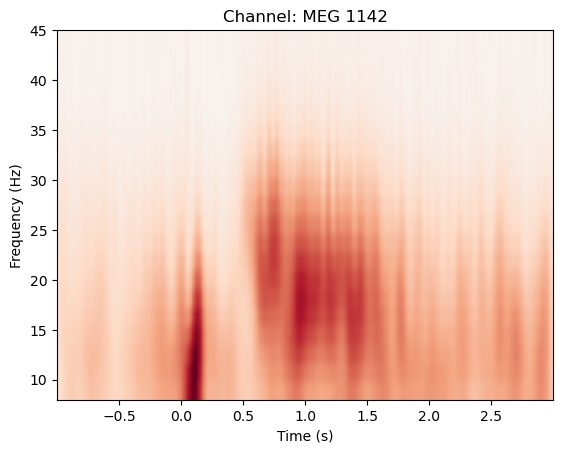

In [78]:
# plot the original data
plt.imshow(
    average_data,
    extent=[power.tmin, power.tmax, power.freqs[0], power.freqs[-1]],
    origin='lower',
    aspect='auto',
    cmap='gray',
)

# plot the parts belonging to a cluster.
max_val = np.nanmax(abs(data_plot))
plt.imshow(
    data_plot,
    extent=[power.tmin, power.tmax, power.freqs[0], power.freqs[-1]],
    origin='lower',
    aspect='auto',
    cmap='RdBu_r',
    vmin=-max_val,
    vmax=max_val
)

plt.title('Channel: %s' % power.ch_names[chan_idx])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')